In [58]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [59]:
dataset_dir = './dataset/training'

labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

In [60]:
%%script false --no-raise-error
num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Couldn't find program: 'false'


In [61]:
SEED = 19011997
SPLIT = 0.1
BATCH_SIZE = 128
IMG_SIZE = (256,256)

## Dataset statistics

Total count: 17728
Apple count: 988
Blueberry count: 467
Cherry count: 583
Corn count: 1206
Grape count: 1458
Orange count: 1748
Peach count: 977
Pepper count: 765
Potato count: 716
Raspberry count: 264
Soybean count: 1616
Squash count: 574
Strawberry count: 673
Tomato count: 5693


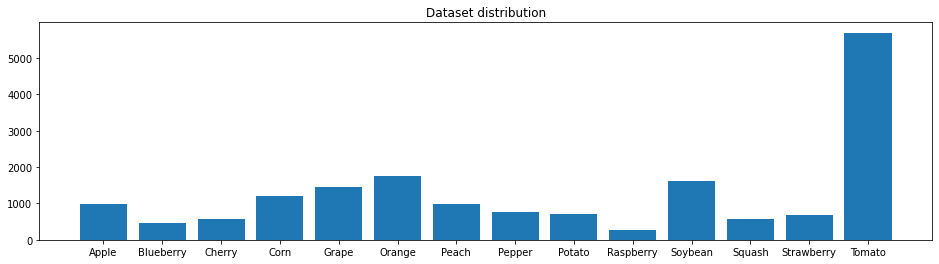

In [62]:
import pathlib

dataset_dir_path = pathlib.Path(dataset_dir)
images_count_total = len(list(dataset_dir_path.glob('*/*.jpg')))
print('Total count: {}'.format(images_count_total))
images_count = {}
for label in labels:
    count = len(list(dataset_dir_path.glob('{}/*.jpg'.format(label))))
    images_count[label] = count
    print('{} count: {}'.format(label, count))
plt.figure(figsize=(16,4))
plt.bar(range(len(labels)), list(images_count.values()))
plt.xticks(range(len(labels)), labels)
plt.title('Dataset distribution')
plt.show()

In [63]:
max_class = max(images_count.values())
class_weights = {}
for k,v in images_count.items():
    class_weights[k] = max_class/v
print(class_weights)

{'Apple': 5.762145748987854, 'Blueberry': 12.190578158458244, 'Cherry': 9.76500857632933, 'Corn': 4.720563847429519, 'Grape': 3.904663923182442, 'Orange': 3.2568649885583523, 'Peach': 5.827021494370522, 'Pepper': 7.441830065359477, 'Potato': 7.951117318435754, 'Raspberry': 21.564393939393938, 'Soybean': 3.5228960396039604, 'Squash': 9.918118466898955, 'Strawberry': 8.459138187221397, 'Tomato': 1.0}


## Load data

[tutorial](https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility)

In [64]:
import tensorflow as tf

def import_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        labels='inferred',
        label_mode='categorical',
        class_names=labels,
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True,
        seed=SEED,
        validation_split=SPLIT,
        subset=subset,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )

dataset_training = import_dataset('training')
dataset_validation = import_dataset('validation')

Found 17728 files belonging to 14 classes.
Using 15956 files for training.
Found 17728 files belonging to 14 classes.
Using 1772 files for validation.


**Dataset shape** `((batch, width?, height?, channels), (batch, classes))`

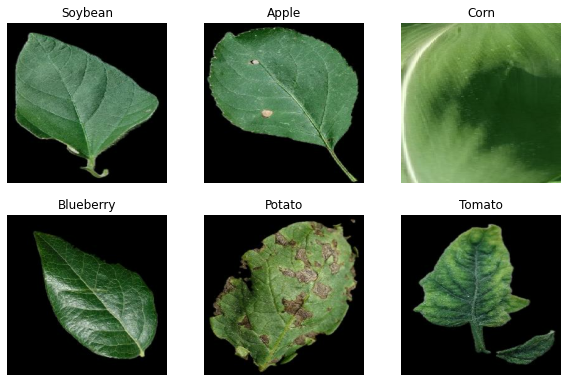

In [65]:
plt.figure(figsize=(10, 10))
for images, onehot in dataset_training.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(np.array(onehot[i]), axis=0)
    plt.title(labels[index])
    plt.axis("off")

[tutorial](https://keras.io/examples/vision/image_classification_from_scratch/)

In [66]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.5, fill_mode='nearest')
    ]
)

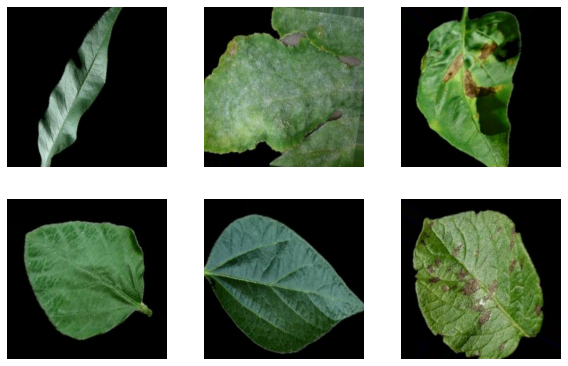

In [67]:
plt.figure(figsize=(10, 10))
for images, _ in dataset_training.take(1):
  for i in range(6):
    augim = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augim[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1./255)(x)

    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Activation('relu')(x)